In [1]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from analysis.plot_matplotlib import plot_hist
from analysis.mc import BinnedImportanceSamplingIntegrator
from analysis import tnp, tnp_mode
import pandas as pd

In [2]:
def integrand(args, mode=0):
    return tnp.exp(-(10)*((args[0]-2)**2)*(args[1]-2)**2) + tnp.exp(-(10)*((args[0]-4)**2)*(args[1]-4)**2)

def integrand_2(args, mode=0):
    r1_2 = (args[0]-2)**2 + (args[1]-2)**2
    r2_2 = (args[0]-4)**2 + (args[1]-4)**2
    
    return tnp.exp(-(10)*r1_2) + tnp.exp(-(10)*r2_2)

# 1D example

In [4]:
tnp_mode(1)

namespace(arange=<function torch._VariableFunctionsClass.arange>,
          array=<function torch._VariableFunctionsClass.tensor>,
          prod=<function analysis.tnp.tnp.<lambda>(tensor, axis=0)>,
          trapz=<function torch._VariableFunctionsClass.trapezoid>,
          argsort=<function torch._VariableFunctionsClass.argsort>,
          sum=<function torch._VariableFunctionsClass.sum>,
          exp=<function torch._VariableFunctionsClass.exp>,
          stack=<function torch._VariableFunctionsClass.stack>,
          random=namespace(choice=<function analysis.tnp.tnp.<lambda>(vals, size)>,
                           uniform=<function analysis.tnp.tnp.<lambda>(low, high)>))

In [13]:
def integrand_1d(args):
    #return -(args[0]-3)**2+5
    #return 1/(args[0]-3)**2
    #return 10*np.exp(-(1/0.01)*(args[0]-3)**2)
    return np.exp(-3*((args[0]-3)**2))

n_tries = 1000
dims = 1
bins_per_dim = 30
boundaries = [
    [0., 6.]
]
instance = BinnedImportanceSamplingIntegrator(bins_per_dim=bins_per_dim, integrand=integrand_1d, dims=dims, boundaries=boundaries)

tensor(1.0473) tensor(5.0000)


Text(0.5, 1.0, '$I=1.02\\pm0.02$')

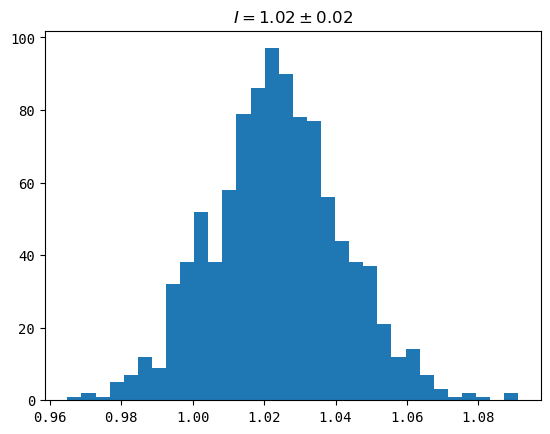

In [24]:
print(instance.integrate(10000), instance.importance_per_dim(0).sum())

res_raw = []
for i in range(n_tries):
    res_raw.append(instance.integrate(10000))

if tnp_mode():
    res_raw = torch.stack(res_raw).numpy()
    
plt.hist(res_raw, bins=32)
plt.title(rf"$I={np.average(res_raw):0.2f}\pm{np.std(res_raw):0.2f}$")

(array([0.16325103, 0.16775103, 0.16790106, 0.17030108, 0.16900102,
        0.16525104, 0.16605105, 0.16880107, 0.16505104, 0.17165108,
        0.16525095, 0.16695115, 0.16870097, 0.16650115, 0.16575095,
        0.16740116, 0.16625095, 0.16205112, 0.16565095, 0.16425094,
        0.16555114, 0.16495094, 0.16530095, 0.17550142, 0.16230093,
        0.17125098, 0.16700096, 0.16335132, 0.16680095, 0.16425094]),
 array([7.05719003e-06, 2.00005800e-01, 4.00004566e-01, 6.00003302e-01,
        8.00002038e-01, 1.00000083e+00, 1.19999957e+00, 1.39999831e+00,
        1.59999704e+00, 1.79999578e+00, 1.99999452e+00, 2.19999337e+00,
        2.39999199e+00, 2.59999084e+00, 2.79998946e+00, 2.99998832e+00,
        3.19998693e+00, 3.39998579e+00, 3.59998441e+00, 3.79998326e+00,
        3.99998212e+00, 4.19998074e+00, 4.39997959e+00, 4.59997845e+00,
        4.79997683e+00, 4.99997568e+00, 5.19997454e+00, 5.39997339e+00,
        5.59997177e+00, 5.79997063e+00, 5.99996948e+00]),
 <BarContainer object of 30 

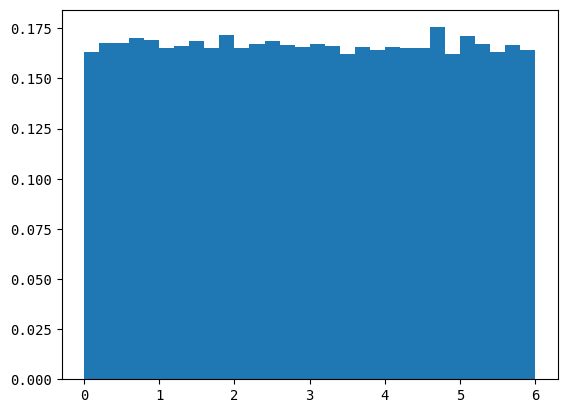

In [25]:
n_samples = 100000
samples = instance.sample(n_samples)
plt.hist(samples[0], density=True, bins=bins_per_dim)
# sns.scatterplot(x=samples[0], y=integrand(samples))

In [26]:
instance.adapt()

(array([0.01410861, 0.01330812, 0.01470897, 0.01480904, 0.01565955,
        0.01370836, 0.01630995, 0.0154094 , 0.01450885, 0.01410862,
        0.01641001, 0.19757054, 0.46748522, 0.73709971, 0.94482645,
        0.94412602, 0.74220283, 0.45447728, 0.18796468, 0.01570958,
        0.01545941, 0.01490911, 0.01605978, 0.01335817, 0.01410859,
        0.01615988, 0.01265771, 0.01490911, 0.01520926, 0.0157096 ]),
 array([3.33755044e-03, 2.03215525e-01, 4.03093487e-01, 6.02971494e-01,
        8.02849412e-01, 1.00272739e+00, 1.20260537e+00, 1.40248334e+00,
        1.60236132e+00, 1.80223930e+00, 2.00211716e+00, 2.20199513e+00,
        2.40187311e+00, 2.60175109e+00, 2.80162907e+00, 3.00150704e+00,
        3.20138502e+00, 3.40126300e+00, 3.60114098e+00, 3.80101895e+00,
        4.00089693e+00, 4.20077515e+00, 4.40065289e+00, 4.60053110e+00,
        4.80040884e+00, 5.00028706e+00, 5.20016479e+00, 5.40004301e+00,
        5.59992075e+00, 5.79979897e+00, 5.99967670e+00]),
 <BarContainer object of 30 

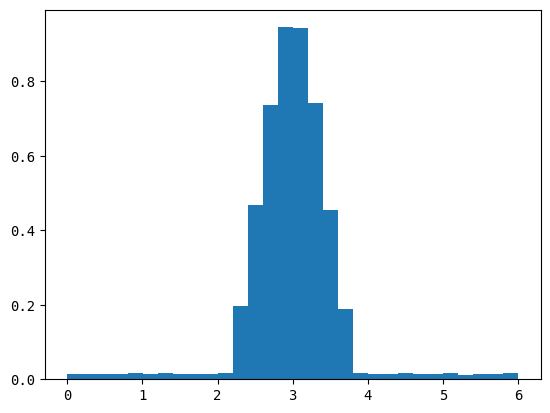

In [27]:
n_samples = 100000
samples = instance.sample(n_samples)
plt.hist(samples[0], density=True, bins=bins_per_dim)
# sns.scatterplot(x=samples[0], y=integrand(samples))

In [29]:
print(instance.integrate(10000), instance.importance_per_dim(0).sum())

res_final = []
for i in range(n_tries):
    res_final.append(instance.integrate(10000))

if tnp_mode():
    res_final = torch.stack(res_final).numpy()

tensor(1.0200) tensor(20.5301)


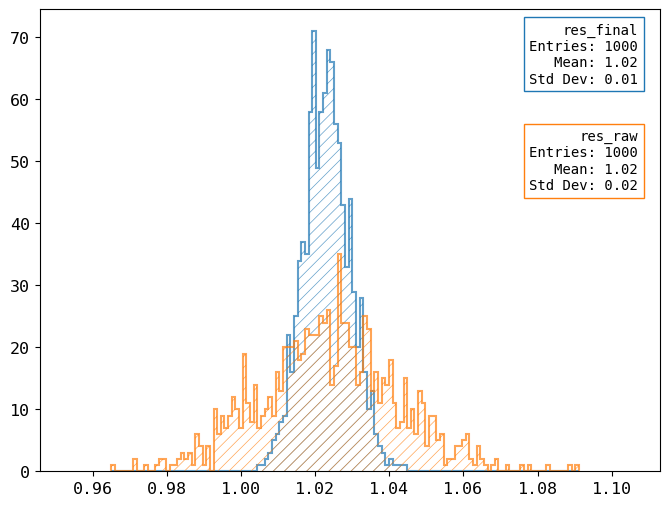

In [30]:
plot_hist(pd.DataFrame(dict(res_final=res_final, res_raw=res_raw)))

In [ ]:
plot_hist(pd.DataFrame(dict(res_final=res_final, res_raw=res_raw)))

# 2D example

In [42]:
tnp_mode(0)

namespace(arange=<function numpy.arange>,
          array=<function numpy.array>,
          prod=<function numpy.prod(a, axis=None, dtype=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)>,
          trapz=<function numpy.trapz(y, x=None, dx=1.0, axis=-1)>,
          argsort=<function numpy.argsort(a, axis=-1, kind=None, order=None)>,
          sum=<function numpy.sum(a, axis=None, dtype=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)>,
          exp=<ufunc 'exp'>,
          stack=<function numpy.stack(arrays, axis=0, out=None, *, dtype=None, casting='same_kind')>,
          random=namespace(choice=<function RandomState.choice>,
                           uniform=<function RandomState.uniform>))

In [5]:
n_tries = 1000
dims = 2
bins_per_dim = 30
boundaries = [
    [0., 6.],
    [0., 6.]
]
instance = BinnedImportanceSamplingIntegrator(bins_per_dim, integrand_2, dims, boundaries, mode=1)

In [6]:
res_raw = []
for i in range(n_tries):
    res_raw.append(instance.integrate(10000))

if tnp_mode():
    res_raw = torch.stack(res_raw).numpy()

In [7]:
instance.integrate(10000)

tensor(0.6120)

(array([[0.03350186, 0.02425135, 0.03000167, 0.02575143, 0.03150175,
         0.0270015 , 0.02825157, 0.02000111, 0.02725151, 0.02400133,
         0.02600144, 0.02900161, 0.02325129, 0.02500139, 0.02550142,
         0.02675148, 0.0270015 , 0.0325018 , 0.02500139, 0.03150175,
         0.02750153, 0.02450136, 0.02450136, 0.0270015 , 0.0287516 ,
         0.02925162, 0.02625146, 0.03300183, 0.02825157, 0.02000111],
        [0.02950164, 0.02800155, 0.02600144, 0.03050169, 0.02400133,
         0.03100172, 0.02925162, 0.02375132, 0.0287516 , 0.02550142,
         0.03025168, 0.0252514 , 0.0287516 , 0.03350186, 0.03000167,
         0.03075171, 0.02925162, 0.02200122, 0.03200178, 0.0252514 ,
         0.03000167, 0.02150119, 0.02775154, 0.03025168, 0.02200122,
         0.02750153, 0.02750153, 0.02450136, 0.0287516 , 0.02625146],
        [0.02925162, 0.0287516 , 0.02275126, 0.02850158, 0.02750153,
         0.02900161, 0.03075171, 0.02575143, 0.02925162, 0.02600144,
         0.02550142, 0.0287516 ,

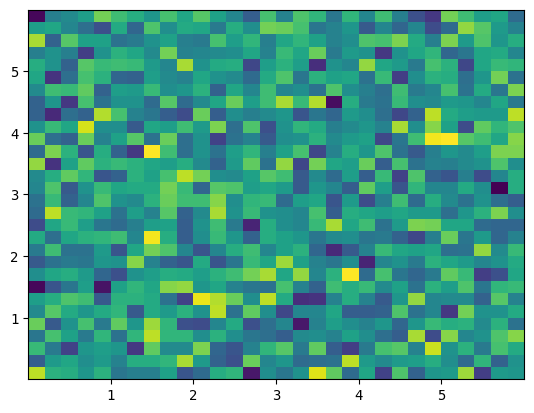

In [8]:
n_samples = 100000
samples = instance.sample(n_samples)
if tnp_mode():
    samples = samples.numpy()

plt.hist2d(samples[0], samples[1], density=True, bins=bins_per_dim)
# sns.scatterplot(x=samples[0], y=integrand(samples))

In [9]:
instance.adapt(n_samples)

(array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.00502495, 0.00753742,
         0.01256237, 0.00251247, 0.        , 0.00251247, 0.00251247,
         0.        , 0.        , 0.00251247, 0.00502495, 0.01507485,
         0.0200998 , 0.01758732, 0.00251247, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.00251247],
        [0.00753742, 0.00251247, 0.        , 0.        , 0.00251247,
         0.        , 0.        , 0.        , 0.00251247, 0.01507485,
         0.01758732, 0.00251247, 0.        , 0.        , 0.00251247,
         0.        , 0.        , 0.        , 0.00502495, 0.01507485,
         0.02512475, 0.00502495, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.00251247, 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.00753742, 0.01256237,
         0.0100499 , 0.00502495,

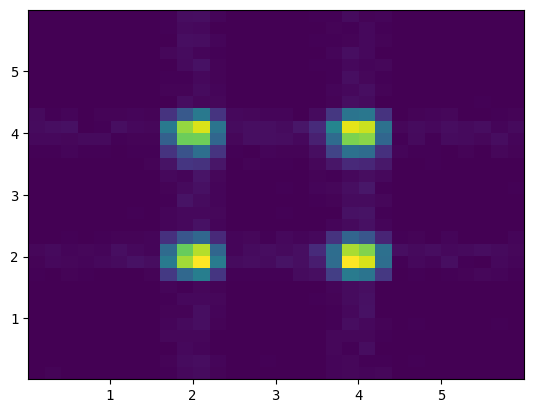

In [10]:
n_samples = 10000
samples = instance.sample(n_samples)
if tnp_mode():
    samples = samples.numpy()

plt.hist2d(samples[0], samples[1], density=True, bins=bins_per_dim)

In [11]:
a = torch.tensor([
    [0.1, 0.2],
    [0.3, 0.5]
])
b = a.numpy()

In [12]:
res_final = []
for i in range(n_tries):
    res_final.append(instance.integrate(10000))

In [13]:
res_final = np.array(res_final)
res_raw = np.array(res_raw)

len(res_final), len(res_raw)

(1000, 1000)

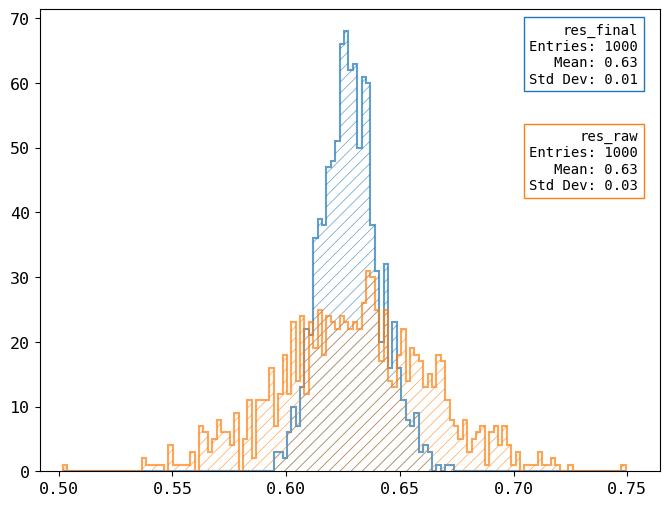

In [15]:
plot_hist(pd.DataFrame(dict(res_final=res_final, res_raw=res_raw)))

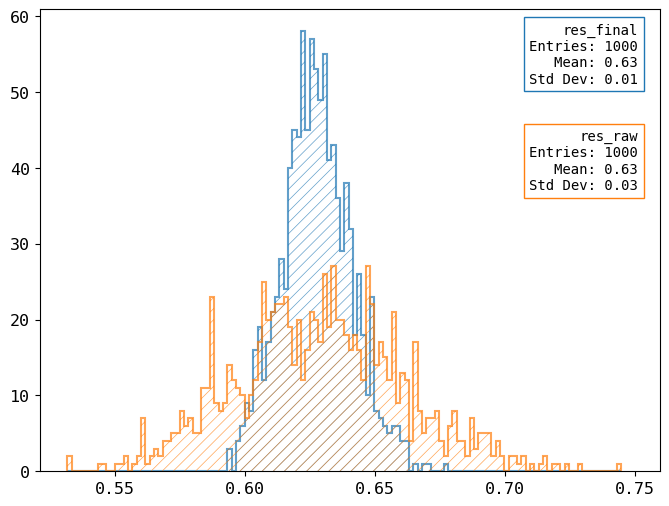

In [51]:
plot_hist(pd.DataFrame(dict(res_final=res_final, res_raw=res_raw)))

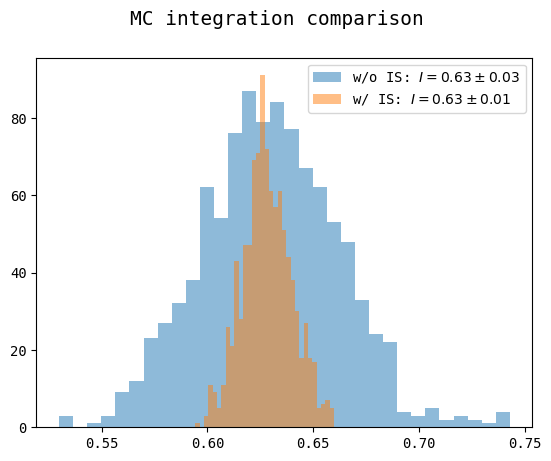

In [61]:
fig, ax = plt.subplots()

fig.suptitle('MC integration comparison', fontsize=14)
ax.hist(res_raw, bins=32, alpha = 0.5, label=rf"w/o IS: $I={np.average(res_raw):0.2f}\pm{np.std(res_raw):0.2f}$")
ax.hist(res_final, bins=32, alpha=0.5, label=rf"w/ IS: $I={np.average(res_final):0.2f}\pm{np.std(res_final):0.2f}$")
ax.legend(loc="upper right")

In [62]:
instance.boundaries

[[0.0, 6.0], [0.0, 6.0]]

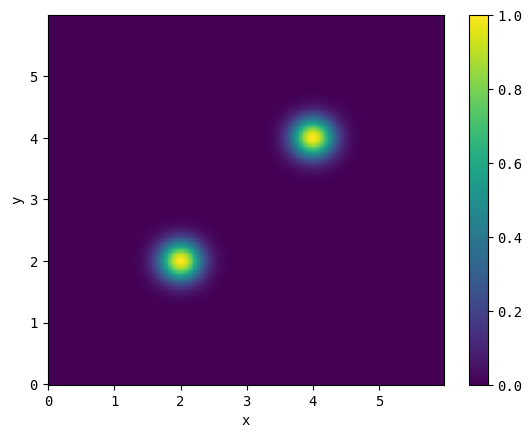

In [52]:
def integrand_2(args, mode=0):
    #return -(args[0]-3)**2+5
    #return 1/(args[0]-3)**2
    #return 10*np.exp(-(1/0.01)*(args[0]-3)**2)
    r1_2 = (args[0]-2)**2 + (args[1]-2)**2
    r2_2 = (args[0]-4)**2 + (args[1]-4)**2
    
    return tnp.exp(-(10)*r1_2) + tnp.exp(-(10)*r2_2)

x = np.arange(instance.boundaries[0][0], instance.boundaries[0][1], 0.02)
y = np.arange(instance.boundaries[1][0], instance.boundaries[1][1], 0.02)
args = np.meshgrid(x, y)
z = integrand_2(args)

plt.pcolormesh(x, y, z)
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()